# Adversarial Robustness v0.1

## Introduction & Setup

Adversarial examples are examples designed in order to cause an machine 

---

learning system to malfunction. Here, an adversary is taking a real image of a panda and adds some adversarially generated noise to get the adversarial example. The adversarial noise is designed to have small distance from the original image, so it still looks like a panda for humans. However, the model now believes its a gibbon with 99.3\% confidence. 

![picture](https://drive.google.com/uc?export=view&id=1kvJRRUDssx8ZarAH71-nxv2c2_RBNz4G)



In [1]:
# Cloning the files from github

!git clone --branch adversarial https://github.com/oliverzhang42/safety.git
!pip3 install robustness=='1.2.1.post2'
!pip3 install torchvision=='0.10.0'

Cloning into 'safety'...
remote: Enumerating objects: 260, done.
remote: Total 260 (delta 0), reused 0 (delta 0), pack-reused 260
Receiving objects: 100% (260/260), 177.09 MiB | 16.19 MiB/s, done.
Resolving deltas: 100% (109/109), done.
Checking out files: 100% (11/11), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 4.4 MB/s 
     |████████████████████████████████| 181 kB 55.6 MB/s 
     |████████████████████████████████| 55 kB 4.6 MB/s 
     |████████████████████████████████| 125 kB 70.0 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=1e78f39d0cfbc73ff9f1196bf33c84cd7258c9da025d2adfb90e6a627a8a3840
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
Looking in indexes: https://pypi.org/simple, https://us-py

In [52]:
# Importing all the necessary libraries

import torch
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from safety.utils import utils
from safety.lesson1 import adversarial
from torch import nn
from torchvision import models
from torch.autograd import grad

%matplotlib inline

## First Adversarial Attack using FGSM

### Untargeted FGSM

The first method we look at is the untargeted Fast Gradient Sign Method (FGSM) proposed by [Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf). The attack constructs adversarial examples as follows:

$$x_\text{adv} = x + \epsilon\cdot\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   $x_\text{adv}$ : Adversarial image.
*   $x$ : Original input image.
*   $y$ : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

The current attack formulation is considered 'untargeted' because it only seeks to maximize loss rather than to trick the model into predicting a specific label. 


Try implementing the untargeted FGSM method for a batch of images yourself!

In [147]:
def untargeted_FGSM(x_batch, true_labels, network, normalize, eps=8/255., **kwargs):
  """Generates a batch of untargeted FGSM adversarial examples

  Args:
    x_batch (torch.Tensor): the batch of unnormalized input examples.
    true_labels (torch.Tensor): the batch of true labels of the example.
    network (nn.Module): the network to attack.
    normalize (function): a function which normalizes a batch of images 
        according to standard imagenet normalization.
    eps (float): the bound on the perturbations.
  """
  loss_fn = nn.CrossEntropyLoss(reduce="mean")
  x_batch.requires_grad = True

  #########################


  
  x_batch_norm = normalize(x_batch)
  y_pred = network(x_batch_norm)
  loss = loss_fn(y_pred, true_labels)

  loss.backward()

  dx_batch = x_batch.grad

  x_adv = x_batch + eps * torch.sign( dx_batch )


  #########################

  return x_adv


torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])
torch.Size([1])
tensor(0.0094, grad_fn=<NllLossBackward>)


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


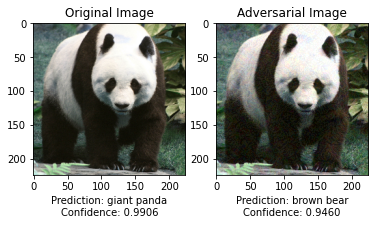

In [151]:
# Test the method
adversarial.test_untargeted_attack(untargeted_FGSM, eps=8/255.)

If things go well, the model should switch from predicting 'giant panda' to predicting 'brown bear' or some other class. Additionally, try increasing the epsilon to see the noise more clearly.

### Targeted FGSM

In addition to the untargeted FGSM which simply seeks to maximize loss, we can also create targeted adversarial attacks. We do this using the following equation:

$$x_{adv} = x - \epsilon\cdot\text{sign}(\nabla_xJ(\theta, x, y_{target}))$$

where 

*   $x_{adv}$ : Adversarial image.
*   $x$ : Original input image.
*   $y_{target}$ : The target label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

Try implementing the targeted FGSM method for a batch of images yourself!

In [160]:
def targeted_FGSM(x_batch, target_labels, network, normalize, eps=8/255., **kwargs):
  """Generates a batch of targeted FGSM adversarial examples

  Args:
    x_batch (torch.Tensor): the unnormalized input example.
    target_labels (torch.Tensor): the labels the model will predict after the attack.
    network (nn.Module): the network to attack.
    normalize (function): a function which normalizes a batch of images 
        according to standard imagenet normalization.
    eps (float): the bound on the perturbations.
  """
  loss_fn = nn.CrossEntropyLoss(reduce="mean")
  x_batch.requires_grad = True

  #########################

  x_batch_norm = normalize(x_batch)
  y_pred = network(x_batch_norm)
  loss = loss_fn(y_pred, target_labels)



  loss.backward()

  dx_batch = x_batch.grad

  x_adv = x_batch - eps * torch.sign( dx_batch )

  #########################
  
  return x_adv

**Note that even if the implementation is perfect, FGSM is not able to generate effective targeted attacks, so don't expect the output image to assign a high probability to the target label.**


The target index corresponds to a label of hen!
tensor([8])


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


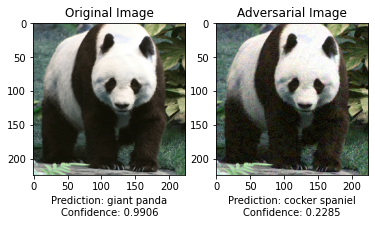

In [165]:
adversarial.test_targeted_attack(targeted_FGSM, target_idx=8, eps=8/255.)

## Additional Adversarial Attacks



## Implementing L2 normalization and clamping

We will implement some helper functions that we can use for the Projected Gradient Descent (PGD) L2 method below.

For the normalize_l2 function we will be returning the following value

$$\frac{x}{||x||_{2}}$$

For the tensor_clamp_l2 function we will compute and return the following value

\begin{equation}
    X=
    \begin{cases}
      clamp(x), & \text{if}\ ||x-c||_2 > r \\
      x, & \text{otherwise}
    \end{cases}
  \end{equation}

where 
$ \text{clamp}(x) = c + \frac{x-c}{||x-c||_2} ⋅ r$, X is the return value, x is the input, c (center) is a tensor of the same shape as x, and r (radius) is a scalar value.

Try implementing the batched version of normalize_l2 and tensor_clamp_l2 below!

In [184]:
def normalize_l2(x_batch):
    """
    Expects x_batch.shape == [N, C, H, W]
    where N is the batch size, 
    C is the channels (or colors in our case),
    H, W are height and width respectively.

    Note: To take the l2 norm of an image, you will want to flatten its dimensions (be careful to preserve the batch dimension of x_batch).
    """
    #########################
    norm = torch.norm(x_batch)
    return x_batch / norm
    #########################

    

In [177]:
def tensor_clamp_l2(x_batch, center, radius):
    """Batched clamp of x into l2 ball around center of given radius."""

    #########################
    

    if torch.norm(x_batch - center) > radius:
      return center + (x_batch - center) * radius / torch.norm(x_batch - center) 

    else:
      return x_batch
    #########################

    

In [178]:
def PGD_l2(x_batch, true_labels, network, normalize, num_steps=20, step_size=3./255, eps=128/255., **kwargs):
        """
        :return: perturbed batch of images
        """
        # Initialize our adversial image
        x_adv = x_batch.detach().clone()
        x_adv += torch.zeros_like(x_adv).uniform_(-eps, eps)

        for _ in range(num_steps):
            x_adv.requires_grad_()
            
            # Calculate gradients
            with torch.enable_grad():
              logits = network(normalize(x_adv))
              loss = F.cross_entropy(logits, true_labels, reduction='sum')

            # Normalize the gradients with your L2
            grad = normalize_l2(torch.autograd.grad(loss, x_adv, only_inputs=True)[0])

            # Take a step in the gradient direction.
            x_adv = x_adv.detach() + step_size * grad
            # Project (by clamping) the adversarial image back onto the hypersphere
            # around the image.
            x_adv = tensor_clamp_l2(x_adv, x_batch, eps).clamp(0, 1)

        return x_adv

Try out the helper functions you wrote. Note how the hyperparameters differ depending on the attack that one is using. You can see more examples below.

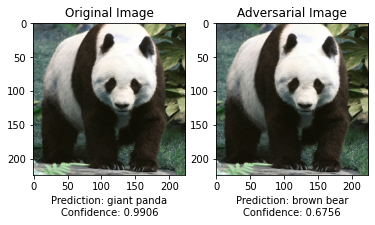

In [265]:
adversarial.test_untargeted_attack(PGD_l2, eps=128/255.)

In addition to your implementations of FGSM, we will provide you with an 

---

implementation of Projected Gradient Descent (PGD) by [Madry et al.](https://arxiv.org/pdf/1706.06083.pdf). As mentioned in the lecture, PGD can be seen a stronger version of FGSM which applies FGSM many times. We provide both targeted and untargeted versions.

In [226]:
def untargeted_PGD(x_batch, true_labels, network, normalize, num_steps=10, step_size=0.01, eps=8/255., **kwargs):
  """Generates a batch of untargeted PGD adversarial examples

  Args:
    x_batch (torch.Tensor): the batch of unnormalized input examples.
    true_labels (torch.Tensor): the batch of true labels of the example.
    network (nn.Module): the network to attack.
    normalize (function): a function which normalizes a batch of images 
        according to standard imagenet normalization.
    num_steps (int): the number of steps to run PGD.
    step_size (float): the size of each PGD step.
    eps (float): the bound on the perturbations.
  """
  x_adv = x_batch.detach().clone()
  x_adv += torch.zeros_like(x_adv).uniform_(-eps, eps)

  for i in range(num_steps):
    x_adv.requires_grad_()
    
    # Calculate gradients
    with torch.enable_grad():
      logits = network(normalize(x_adv))
      loss = F.cross_entropy(logits, true_labels, reduction='sum')
    grad = torch.autograd.grad(loss, x_adv, only_inputs=True)[0]
    
    # Perform one gradient step
    x_adv = x_adv.detach() + step_size * torch.sign(grad.detach())
    
    # Project the image to the ball.
    x_adv = torch.maximum(x_adv, x_batch - eps)
    x_adv = torch.minimum(x_adv, x_batch + eps)

  return x_adv

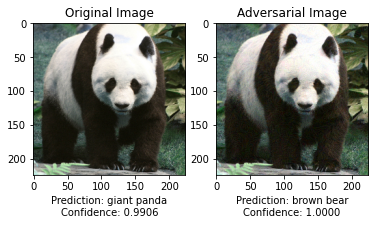

In [227]:
adversarial.test_untargeted_attack(untargeted_PGD, eps=8/255.)

In [186]:
def targeted_PGD(x_batch, target_labels, network, normalize, num_steps=100, step_size=0.01, eps=8/255., **kwargs):
  """Generates a batch of untargeted PGD adversarial examples

  Args:
    x_batch (torch.Tensor): the batch of preprocessed input examples.
    target_labels (torch.Tensor): the labels the model will predict after the attack.
    network (nn.Module): the network to attack.
    normalize (function): a function which normalizes a batch of images 
        according to standard imagenet normalization.
    num_steps (int): the number of steps to run PGD.
    step_size (float): the size of each PGD step.
    eps (float): the bound on the perturbations.
  """
  x_adv = x_batch.detach().clone()
  x_adv += torch.zeros_like(x_adv).uniform_(-eps, eps)

  for i in range(num_steps):
    x_adv.requires_grad_()
    
    # Calculate gradients
    with torch.enable_grad():
      logits = network(normalize(x_adv))
      loss = F.cross_entropy(logits, target_labels, reduction='sum')
    grad = torch.autograd.grad(loss, x_adv, only_inputs=True)[0]
    
    # Perform one gradient step
    # Note that this time we use gradient descent instead of gradient ascent
    x_adv = x_adv.detach() - step_size * torch.sign(grad.detach())
    
    # Project the image to the ball
    x_adv = torch.maximum(x_adv, x_batch - eps)
    x_adv = torch.minimum(x_adv, x_batch + eps)
  
  return x_adv


The target index corresponds to a label of goldfish!


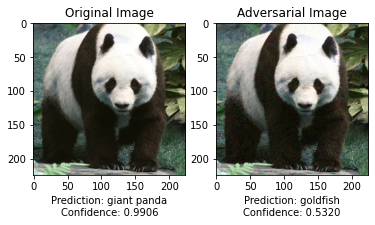

In [187]:
# Try changing the target_idx around!
adversarial.test_targeted_attack(targeted_PGD, target_idx=1, eps=8/255.)

## Attacks on Adversarially Trained Models
We devote this section to attacking an adversarially trained model. As a reminder, a model which has been "adversarially trained" means that it has been exposed to a load of adversarial examples over training and has specifically trained to recognize them properly.

In this section, we hope to demonstrate that adversarial attacks look a lot different if you're attacking an adversarially trained model.

The model we use was taken from this repository and is an L∞ robust ResNet18 trained with adversarial examples of ϵ=8/255.

### Attacking Normally Trained Models


The target index corresponds to a label of brambling!


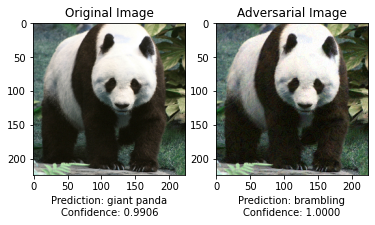

In [188]:
# Attack a normal model (we only support targeted methods)
adversarial.attack_normal_model(
    targeted_PGD, 
    target_idx=10, 
    eps=8/255., 
    num_steps=10, 
    step_size=0.01
)

### Attacking Adversarially Trained Models

=> loading checkpoint 'safety/lesson1/checkpoints/resnet18_linf_eps8.0.ckpt'
=> loaded checkpoint 'safety/lesson1/checkpoints/resnet18_linf_eps8.0.ckpt' (epoch 90)

The target index corresponds to a label of brambling!


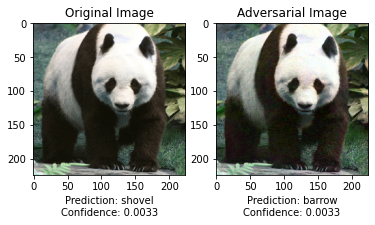

In [190]:
# Attack an adversarially trained model (we only support targeted methods)
adversarial.attack_adversarially_trained_model(
    targeted_PGD, 
    target_idx=10, 
    eps=8/255., 
    num_steps=10, 
    step_size=0.01
)

### Comparing Adversarial Attacks against different models

Take a few minutes to play around with the previous code. Jot down three observations about how attacking an adversarially trained model differs from attacking a normal model.

Example responses:

1. The confidence of typical models is higher than adversarially trained models
2. The prdicted label is still wrong
3. the low confidence could be a telltale sign that an attack has occured

## Accuracy vs Number of PGD Steps

In this section, we seek to see how accuracy varies as we change the number of steps in PGD. Your first task is to write a function which calculates the model's accuracy on adversarially generated images. For this case, we use untargeted PGD.

In [238]:
def adversarial_accuracy(x_batch, true_labels, network, normalize, num_steps=10, step_size=0.01, eps=100/255.):
    """Generates a batch of adversarial examples using `untargeted_PGD`. Then
    calculates and returns accuracy on said batch of examples.

    Args:
      x_batch (torch.Tensor): the batch of preprocessed input examples.
      true_labels (torch.Tensor): the batch of true labels of the example.
      network (nn.Module): the network to attack.
      normalize (function): a function which normalizes a batch of images 
          according to standard imagenet normalization.
      num_steps (int): the number of steps to run PGD.
      step_size (float): the size of each PGD step.
      eps (float): the bound on the perturbations.

    Note: Consider the networks prediction to be the class with the highest output (aka logit).
    """
    x_adv = untargeted_PGD(x_batch, true_labels, network, normalize, num_steps=num_steps, step_size=step_size, eps=eps)

    #########################


    y_pred = network(x_adv)

    y_pred_num = torch.argmax(y_pred, dim = 1)

    accuracy = (torch.sum(y_pred_num == true_labels)) / len(y_pred)

    print(torch.sum(y_pred_num == true_labels))

    #########################

    return accuracy

Then, use the previous function to plot the accuracy against the number of PGD steps.

In [259]:
x_batch = torch.load('safety/lesson1/imagenet_batch').cuda()
true_labels = torch.load('safety/lesson1/imagenet_labels').cuda()
network = adversarial.get_adv_trained_model().eval()
normalization_function = utils.IMAGENET_NORMALIZE

#########################

num = 12

arr = [0]*num

for i in range(num):
  arr[i] = adversarial_accuracy(x_batch, true_labels, network, normalization_function, num_steps = i*5)

for i in range(num):
  arr[i] = float(arr[i])


#########################

# call adversarial_accuracy(...) for several num_steps and plot

=> loading checkpoint 'safety/lesson1/checkpoints/resnet18_linf_eps8.0.ckpt'
=> loaded checkpoint 'safety/lesson1/checkpoints/resnet18_linf_eps8.0.ckpt' (epoch 90)
tensor(30)
tensor(29)
tensor(29)
tensor(29)
tensor(28)
tensor(27)
tensor(26)
tensor(24)
tensor(24)
tensor(21)
tensor(22)
tensor(21)


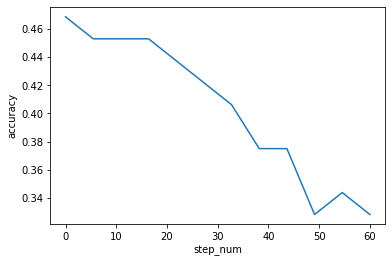

In [266]:
import numpy as np
plt.plot(np.linspace(0, num * 5, num),arr)
plt.ylabel("accuracy")
plt.xlabel("step_num")
plt.show()